In [1]:
#-----------------------------------#
# Target: for integrating the forecasted data
# FOST only receives .csv
# DATA: predicted IMFS and smapi within Huai river Plain 
# This practice is to remove all the invalid grids (for reducing computation) 
# author: X.W.
# 6-26-2022
#-----------------------------------#
import xarray as xr
import pandas as pd
#import geopandas as gpd
import numpy as np
import os
import glob
from tqdm.notebook import tqdm

In [2]:
# 读取文件名的函数
def read_file(path, file_type):  # path 是指需要提取的文件夹所在路径;file_type是指文件的拓展名;txt格式的文件则输入‘.txt’
    filenames = os.listdir(path)
    filenames1 = []
    for filename in filenames:
        if os.path.splitext(filename)[1] == file_type:
            filenames1.append(filename)
    return filenames1

In [3]:
os.chdir(r'E:\Data_inputs\masked_data_HRB')  # 更改工作路径
curr_path = os.getcwd()  # 获取当前路径
files = read_file(curr_path, '.nc')  # 利用上述函数获取当前文件夹内的.nc文件名
# 最后一个文件是smapi，注意区分
data = xr.open_dataset(files[0])
dt = data['imf'].values
df = pd.DataFrame(dt.reshape((dt.shape[0],-1)))
# id_nan = df[df.columns[df.isnull().any()]].columns

In [4]:
# 方案1：把所有预测文件进行汇总
# 方案2：把所有预测文件单独存储（每个月存储起来）
# 目前采取方案1

In [5]:
root = 'E:\\Data_inputs\\fost_outputs_VAL_v1'
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item))]
date = pd.date_range(start='2019-3-3', periods=100, freq='7D').tolist()
for ii in tqdm(range(len(dirlist))):
    dir_path = root+'\\'+dirlist[ii]
    os.chdir(dir_path)
    curr_path = os.getcwd()  # 获取当前路径
    files = read_file(curr_path, '.csv')  # 利用上述函数获取当前文件夹内的.nc文件名
    smi_apd = []
    for jj in range(len(files)):
        test_y = pd.read_csv(files[jj])
        test_y = test_y.pivot(index='Date', columns='Node')['TARGET']
        med_df = df.loc[:3,:].copy()
        med_df.iloc[:,test_y.columns.values] = test_y.to_numpy()
        smi_apd.append(med_df)
    smi_apd = pd.concat(smi_apd).to_numpy()
    smi_apd = np.reshape(smi_apd,(smi_apd.shape[0],64,104))
    smi_apd.shape
    da = xr.Dataset(
        {'imf': (("time","rows", "colms"), smi_apd)},
        coords=dict(
            time=date,
            lon=(["rows","colms"], data.lon.values),
            lat=(["rows","colms"], data.lat.values),
        ),
        attrs=dict(
            description="Appended predicted data ",
            units="refer to the variable",
        ),  
        )
    da.to_netcdf('E:\\Data_inputs\\fost_appended_outputs_v1\\'+'Appended_predicted_imfs_'+str(ii)+'_from_Mar2019_to_Dec2020.nc')

  0%|          | 0/8 [00:00<?, ?it/s]

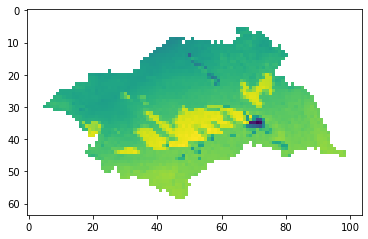

In [6]:
import pylab as plt
plt.imshow(smi_apd[2,:,:])

In [38]:
dir_append = r'E:\Data_inputs\fost_appended_outputs_v1'
os.chdir(dir_append)
curr_path = os.getcwd()  # 获取当前路径
files = read_file(curr_path, '.nc')  # 利用上述函数获取当前文件夹内的.nc文件名
files

['Appended_predicted_imfs_0_from_Mar2019_to_Dec2020.nc',
 'Appended_predicted_imfs_1_from_Mar2019_to_Dec2020.nc',
 'Appended_predicted_imfs_2_from_Mar2019_to_Dec2020.nc',
 'Appended_predicted_imfs_3_from_Mar2019_to_Dec2020.nc',
 'Appended_predicted_imfs_4_from_Mar2019_to_Dec2020.nc',
 'Appended_predicted_imfs_5_from_Mar2019_to_Dec2020.nc',
 'Appended_predicted_imfs_6_from_Mar2019_to_Dec2020.nc',
 'Appended_predicted_imfs_7_from_Mar2019_to_Dec2020.nc',
 'smapi_aggregated_from_IMFs_from_Mar2019_to_Dec2020.nc']

In [39]:
sum_imf = np.zeros([100,64,104])
date = pd.date_range(start='2019-3-3', periods=100, freq='7D').tolist()
for ii in range(6):
    med_df = xr.open_dataset(files[ii])
    sub_imf = med_df['imf'].values
    sum_imf = sum([sum_imf, sub_imf])
print(np.nanmax(sum_imf),np.nanmin(sum_imf),np.nanmedian(sum_imf))
da = xr.Dataset(
    {'smapi': (("time","rows", "colms"), sum_imf)},
    coords=dict(
        time=date,
        lon=(["rows","colms"], data.lon.values),
        lat=(["rows","colms"], data.lat.values),
    ),
    attrs=dict(
        description="Appended predicted data ",
        units="refer to the variable",
    ),  
    )
da.to_netcdf('E:\\Data_inputs\\fost_appended_outputs_v1\\'+
             'smapi_aggregated_from_IMFs_from_Mar2019_to_Dec2020.nc')

1.036514379789031 -0.8977322179116505 -0.0139696481474389


In [8]:
# 因为最后一个imf实际上为预测的SMI，因此排除
sum_imf = np.zeros([100,64,104])
date = pd.date_range(start='2019-3-3', periods=100, freq='7D').tolist()
for ii in range(len(files)-2):
    med_df = xr.open_dataset(files[1])
    sub_imf = med_df['imf'].values
    sum_imf = sum([sum_imf, sub_imf])
da = xr.Dataset(
    {'smapi': (("time","rows", "colms"), sum_imf)},
    coords=dict(
        time=date,
        lon=(["rows","colms"], data.lon.values),
        lat=(["rows","colms"], data.lat.values),
    ),
    attrs=dict(
        description="Appended predicted data ",
        units="refer to the variable",
    ),  
    )
da.to_netcdf('E:\\Data_inputs\\fost_appended_outputs_v1\\'+
             'smapi_aggregated_from_IMFs_from_Mar2019_to_Dec2020.nc')

In [40]:
print(np.nanmax(sum_imf),np.nanmin(sum_imf),np.nanmedian(sum_imf))

1.036514379789031 -0.8977322179116505 -0.0139696481474389


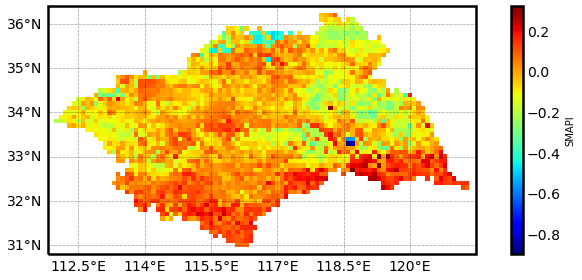

In [37]:
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import os

data = med_df
fig = plt.figure(figsize=(10, 4))
plt.rcParams['axes.linewidth'] = 2.5
ax = plt.subplot(projection=ccrs.PlateCarree())
# plt.title('From '+str(df_predict.loc['TARGET'].index[0])[0:10]+' to '+
#           str(df_predict.loc['TARGET'].index[-1])[0:10], fontsize=16, weight='bold')

cmap = plt.get_cmap('jet')
dtplot = plt.pcolormesh(data.lon.values,data.lat.values,sum_imf[58,:,:],cmap=cmap)#,vmin = -1,vmax =1)
#plt.plot(x,y,c='k')
cbar = plt.colorbar(dtplot, label='SMAPI')
cbar.ax.axes.tick_params(length=0)
cbar.ax.tick_params(labelsize=14)
ax.set_aspect('equal')
gl=ax.gridlines(draw_labels=True,linestyle=":",linewidth=0.5,color='k')
gl.top_labels=False #关闭上部经纬标签                                  
gl.right_labels=False
gl.ylocator = mticker.FixedLocator(np.arange(31,37.5,1))
gl.xformatter = LONGITUDE_FORMATTER  #使横坐标转化为经纬度格式            
gl.yformatter = LATITUDE_FORMATTER  
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
plt.axis([111.8,121.5,30.8,36.4])
plt.tight_layout()

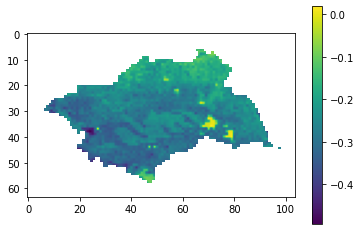

In [31]:
plt.imshow(sum_imf[3,:,:])
plt.colorbar()

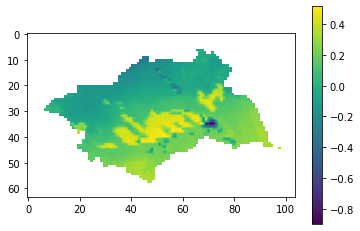

In [30]:
med_df = xr.open_dataset(files[-1])
sub_imf = med_df['imf'].values
plt.imshow(sub_imf[3,:,:])
plt.colorbar()

In [13]:
med_df = xr.open_dataset(files[0])
sub_imf = med_df['imf'].values

(88, 64, 104)

In [16]:
sum_imf = sum([sub_imf, sub_imf, sub_imf])

In [17]:
sum_imf[1,45,24]

0.0859438326795444

In [18]:
sub_imf[1,45,24]

0.0286479442265148